# Gradient Descent with BQN Expressions on JAX

This notebook demonstrates how to use `bqn-jax`'s compile path to express
mathematical functions in BQN notation, then optimize them with JAX's
automatic differentiation.

We'll fit a curve to noisy data using gradient descent — with the model,
loss, and update rules all written as compiled BQN expressions.

In [27]:
from pathlib import Path
import sys

def _find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists() and (candidate / "src" / "bqn_jax").exists():
            return candidate
    raise RuntimeError("Could not locate the bqn-jax repo root.")

_repo_root = _find_repo_root(Path.cwd())
_src = _repo_root / "src"
if str(_src) not in sys.path:
    sys.path.insert(0, str(_src))

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from bqn_jax import ShapePolicy, compile_expression

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
print(f"JAX version: {jax.__version__}")

JAX version: 0.9.0.1


## Problem: Fit a Curve to Noisy Data

We'll generate noisy samples from a polynomial:

$$y = 0.5\sin(2\pi x) + 0.3\cos(4\pi x)$$

and fit a degree-4 polynomial to it using gradient descent,
with the polynomial evaluation and loss written in BQN.

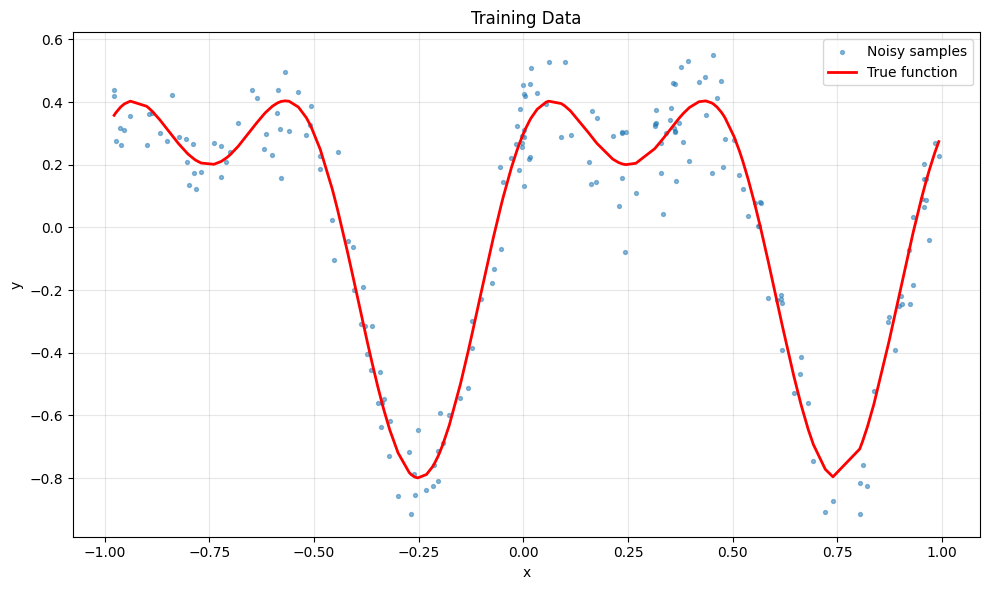

In [28]:
# Generate noisy training data
key = jax.random.PRNGKey(42)
k1, k2 = jax.random.split(key)

N = 200
x_data = jax.random.uniform(k1, (N,), minval=-1.0, maxval=1.0)
x_data = jnp.sort(x_data)
y_true = 0.5 * jnp.sin(2 * jnp.pi * x_data) + 0.3 * jnp.cos(4 * jnp.pi * x_data)
noise = 0.1 * jax.random.normal(k2, (N,))
y_data = y_true + noise

plt.figure()
plt.scatter(x_data, y_data, s=8, alpha=0.5, label='Noisy samples')
plt.plot(np.array(x_data), np.array(y_true), 'r-', lw=2, label='True function')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Training Data')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## BQN Expressions

Eight BQN expressions define the entire model and optimizer:

| # | Purpose | BQN |
|---|---------|-----|
| 1 | Polynomial (dot product) | `+´(c×f)` |
| 2 | MSE loss | `+´×˜(p-y)÷≠y` |
| 3 | RMSE | `√+´×˜(p-y)÷≠y` |
| 4 | Adam momentum | `(beta1×m)+((1-beta1)×g)` |
| 5 | Adam velocity | `(beta2×v)+((1-beta2)××˜g)` |
| 6 | Bias-correct m | `m÷(1-(beta1⋆t))` |
| 7 | Bias-correct v | `v÷(1-(beta2⋆t))` |
| 8 | Parameter update | `p-(lr×mhat÷((√vhat)+eps))` |

In [29]:
_STATIC  = ShapePolicy(kind="static")
_DYNAMIC = ShapePolicy(kind="dynamic")
_ce_s = lambda expr, names: compile_expression(expr, arg_names=names, shape_policy=_STATIC)
_ce_d = lambda expr, names: compile_expression(expr, arg_names=names, shape_policy=_DYNAMIC)

# ── model ──
POLY_EXPR = "+´(c×f)"
poly_fn   = _ce_d(POLY_EXPR, ("c", "f"))
poly_map  = poly_fn.vmap(in_axes=(None, 0), out_axes=0)

# ── loss ──
MSE_EXPR  = "+´×˜(p-y)÷≠y"
mse_fn    = _ce_s(MSE_EXPR, ("p", "y"))
RMSE_EXPR = "√+´×˜(p-y)÷≠y"
rmse_fn   = _ce_d(RMSE_EXPR, ("p", "y"))

# ── Adam optimizer (all in BQN) ──
ADAM_M    = "(beta1×m)+((1-beta1)×g)"
ADAM_V    = "(beta2×v)+((1-beta2)××˜g)"
ADAM_MHAT = "m÷(1-(beta1⋆t))"
ADAM_VHAT = "v÷(1-(beta2⋆t))"
ADAM_UPD  = "p-(lr×mhat÷((√vhat)+eps))"

muf = _ce_s(ADAM_M,    ("m", "g", "beta1"))
vuf = _ce_s(ADAM_V,    ("v", "g", "beta2"))
mhf = _ce_s(ADAM_MHAT, ("m", "beta1", "t"))
vhf = _ce_s(ADAM_VHAT, ("v", "beta2", "t"))
puf = _ce_s(ADAM_UPD,  ("p", "mhat", "vhat", "lr", "eps"))

exprs = [POLY_EXPR, MSE_EXPR, RMSE_EXPR, ADAM_M, ADAM_V, ADAM_MHAT, ADAM_VHAT, ADAM_UPD]
print(f"8 BQN expressions compiled to JAX:")
for i, e in enumerate(exprs, 1):
    print(f"  {i}. {e}")

8 BQN expressions compiled to JAX:
  1. +´(c×f)
  2. +´×˜(p-y)÷≠y
  3. √+´×˜(p-y)÷≠y
  4. (beta1×m)+((1-beta1)×g)
  5. (beta2×v)+((1-beta2)××˜g)
  6. m÷(1-(beta1⋆t))
  7. v÷(1-(beta2⋆t))
  8. p-(lr×mhat÷((√vhat)+eps))


## Training Loop

We use JAX's `jax.value_and_grad` to differentiate through the BQN-compiled
loss function, then apply the Adam optimizer — also expressed in BQN.

In [30]:
DEGREE = 16
coeffs = jnp.zeros(DEGREE + 1, dtype=jnp.float32)

def make_features(xs, degree):
    """Build Vandermonde matrix: [1, x, x², …, x^degree] for each x."""
    return jnp.stack([xs ** i for i in range(degree + 1)], axis=-1)

F_train = make_features(x_data, DEGREE)

def predict(c, features):
    return poly_map(c, features)

def loss(c, features, ys):
    return mse_fn(predict(c, features), ys)

# Hyperparameters
LR    = jnp.float32(0.01)
BETA1 = jnp.float32(0.9)
BETA2 = jnp.float32(0.999)
EPS   = jnp.float32(1e-8)

# Adam state
m_state = jnp.zeros_like(coeffs)
v_state = jnp.zeros_like(coeffs)
t_step  = jnp.float32(1.0)

@jax.jit
def train_step(c, m, v, t, features, ys):
    l, g = jax.value_and_grad(loss)(c, features, ys)
    m = muf(m, g, BETA1)
    v = vuf(v, g, BETA2)
    mhat = mhf(m, BETA1, t)
    vhat = vhf(v, BETA2, t)
    c = puf(c, mhat, vhat, LR, EPS)
    return c, m, v, t + 1.0, l

epochs = 2000
log_every = 100
losses = []
snapshots = {}

for epoch in range(epochs):
    coeffs, m_state, v_state, t_step, l = train_step(
        coeffs, m_state, v_state, t_step, F_train, y_data
    )
    losses.append(float(l))
    if epoch % log_every == 0 or epoch == epochs - 1:
        r = float(rmse_fn(predict(coeffs, F_train), y_data))
        print(f"epoch {epoch:5d}  loss={float(l):.6f}  rmse={r:.4f}")
        snapshots[epoch] = np.array(coeffs)

print(f"\nFinal coefficients: {np.array(coeffs).round(4)}")

epoch     0  loss=0.000795  rmse=0.0278
epoch   100  loss=0.000542  rmse=0.0233
epoch   200  loss=0.000474  rmse=0.0218
epoch   300  loss=0.000441  rmse=0.0210
epoch   400  loss=0.000412  rmse=0.0203
epoch   500  loss=0.000385  rmse=0.0196
epoch   600  loss=0.000360  rmse=0.0190
epoch   700  loss=0.000338  rmse=0.0184
epoch   800  loss=0.000319  rmse=0.0179
epoch   900  loss=0.000303  rmse=0.0174
epoch  1000  loss=0.000290  rmse=0.0170
epoch  1100  loss=0.000279  rmse=0.0167
epoch  1200  loss=0.000271  rmse=0.0165
epoch  1300  loss=0.000264  rmse=0.0163
epoch  1400  loss=0.000259  rmse=0.0161
epoch  1500  loss=0.000255  rmse=0.0160
epoch  1600  loss=0.000251  rmse=0.0158
epoch  1700  loss=0.000248  rmse=0.0158
epoch  1800  loss=0.000246  rmse=0.0157
epoch  1900  loss=0.000244  rmse=0.0156
epoch  1999  loss=0.000242  rmse=0.0156

Final coefficients: [ 0.0088  1.9672  0.1525 -7.2388  1.168  -0.2521 -5.3763  5.4795  0.0104
  4.8662  4.1711  1.1747  3.6112 -2.2071  0.376  -4.2132 -3.6821]


## Loss Curve

Watch the MSE drop over training iterations.

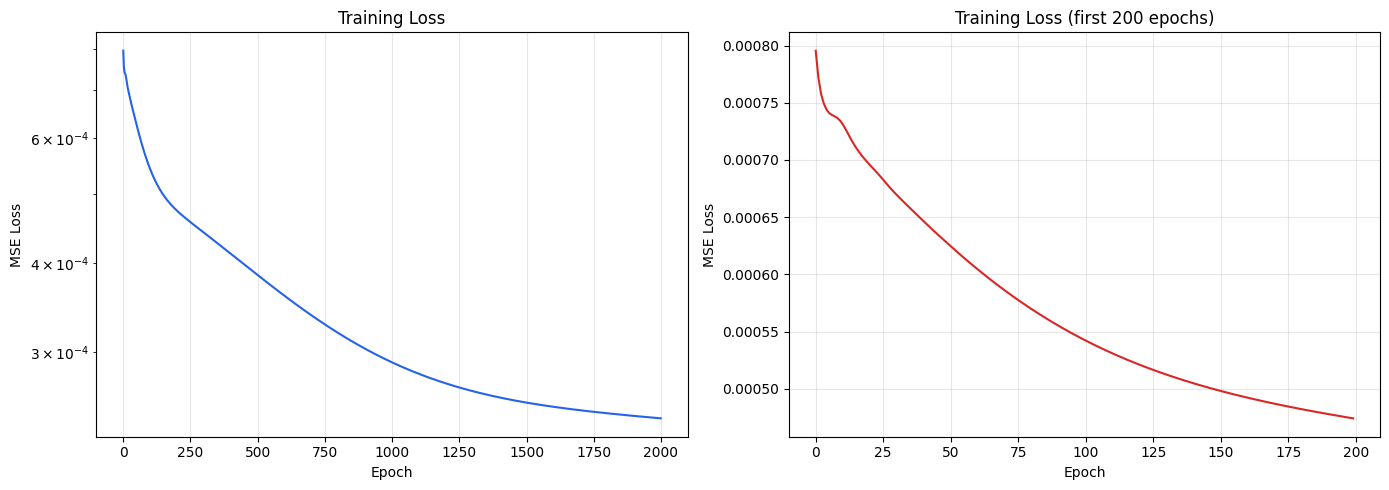

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(losses, color='#2563eb', lw=1.5)
ax1.set_xlabel('Epoch'); ax1.set_ylabel('MSE Loss')
ax1.set_title('Training Loss')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

ax2.plot(losses[:200], color='#dc2626', lw=1.5)
ax2.set_xlabel('Epoch'); ax2.set_ylabel('MSE Loss')
ax2.set_title('Training Loss (first 200 epochs)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Fit Progression

See how the polynomial fit evolves from a flat line to tracking the target.

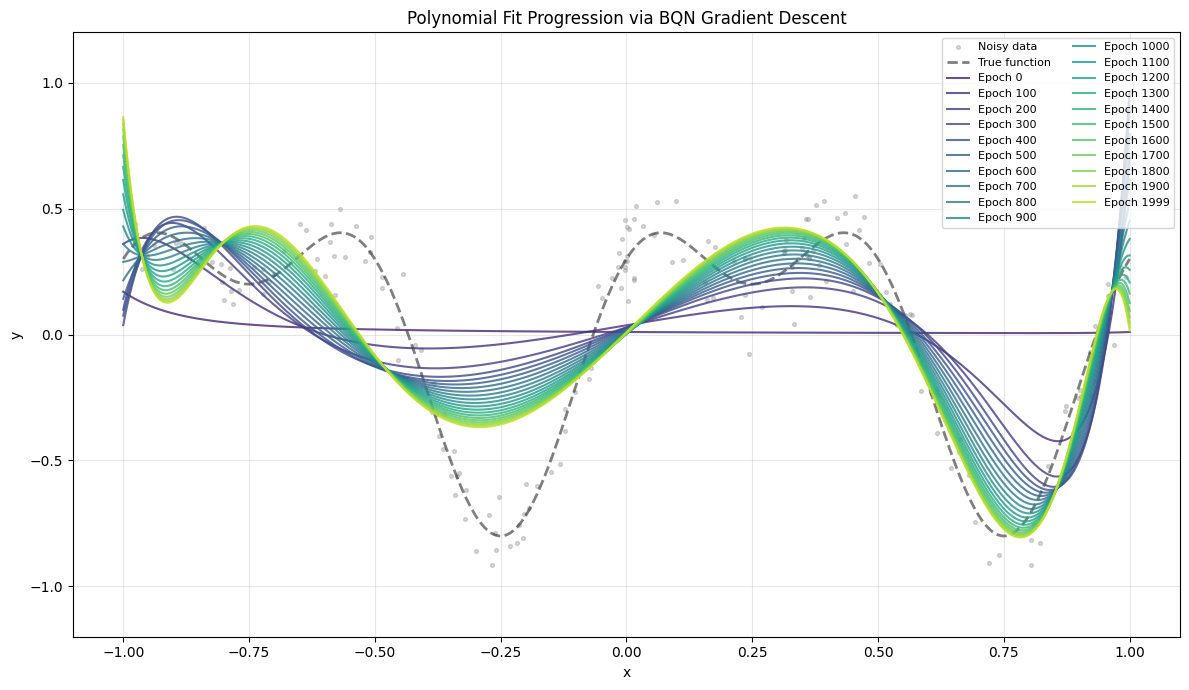

In [32]:
x_plot = jnp.linspace(-1.0, 1.0, 500)
F_plot = make_features(x_plot, DEGREE)
y_plot_true = 0.5 * jnp.sin(2 * jnp.pi * x_plot) + 0.3 * jnp.cos(4 * jnp.pi * x_plot)

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(x_data, y_data, s=8, alpha=0.3, color='gray', label='Noisy data', zorder=1)
ax.plot(np.array(x_plot), np.array(y_plot_true), 'k--', lw=2, alpha=0.5, label='True function', zorder=2)

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(snapshots)))
for (ep, c), color in zip(sorted(snapshots.items()), colors):
    y_pred = np.array(predict(jnp.array(c), F_plot))
    ax.plot(np.array(x_plot), y_pred, color=color, lw=1.5, alpha=0.8, label=f'Epoch {ep}')

ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Polynomial Fit Progression via BQN Gradient Descent')
ax.legend(fontsize=8, ncol=2, loc='upper right')
ax.set_ylim(-1.2, 1.2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Gradient Landscape

Visualize how the loss changes as we perturb two of the coefficients
around their final values.

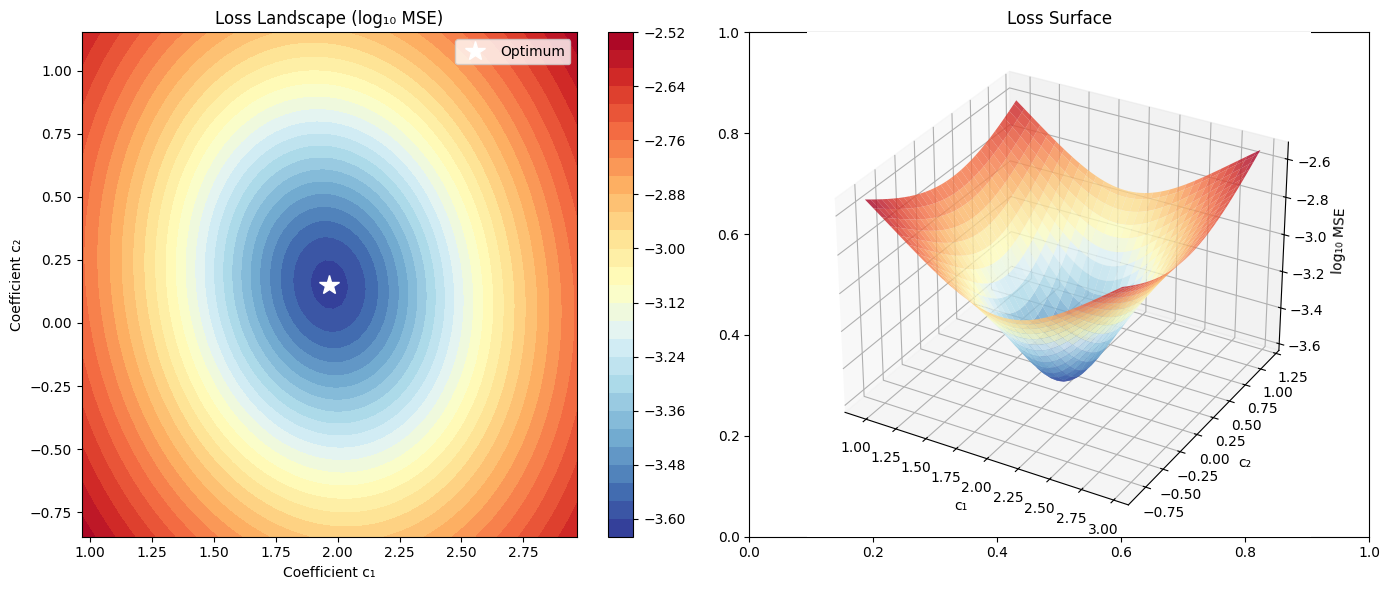

In [33]:
# Perturb coefficients 1 and 2 around their optimized values
c_final = coeffs
grid_n = 60
r = 1.0
c1_range = np.linspace(float(c_final[1]) - r, float(c_final[1]) + r, grid_n)
c2_range = np.linspace(float(c_final[2]) - r, float(c_final[2]) + r, grid_n)
C1, C2 = np.meshgrid(c1_range, c2_range)
Z = np.zeros_like(C1)

for i in range(grid_n):
    for j in range(grid_n):
        c_test = c_final.at[1].set(C1[i, j]).at[2].set(C2[i, j])
        Z[i, j] = float(loss(c_test, F_train, y_data))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Contour plot
cs = ax1.contourf(C1, C2, np.log10(Z + 1e-8), levels=30, cmap='RdYlBu_r')
ax1.plot(float(c_final[1]), float(c_final[2]), 'w*', ms=15, zorder=5, label='Optimum')
ax1.set_xlabel('Coefficient c₁'); ax1.set_ylabel('Coefficient c₂')
ax1.set_title('Loss Landscape (log₁₀ MSE)')
ax1.legend()
plt.colorbar(cs, ax=ax1)

# 3D surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(C1, C2, np.log10(Z + 1e-8), cmap='RdYlBu_r', alpha=0.8)
ax2.set_xlabel('c₁'); ax2.set_ylabel('c₂'); ax2.set_zlabel('log₁₀ MSE')
ax2.set_title('Loss Surface')

plt.tight_layout()
plt.show()

## Final Comparison

Compare the BQN-fitted polynomial against the true underlying function.

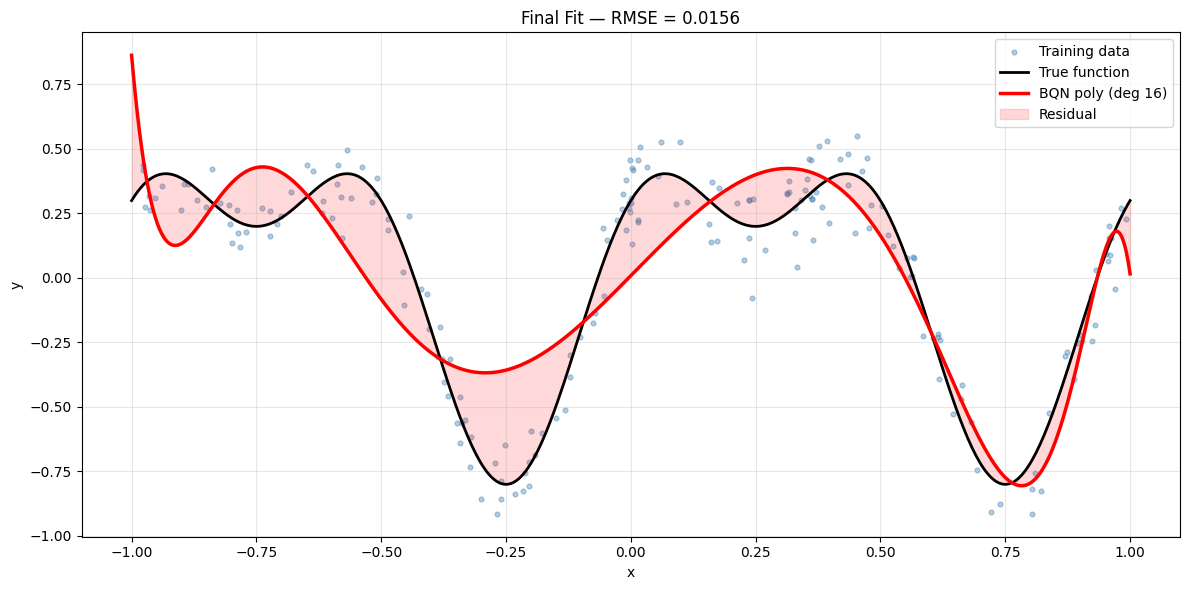


8 BQN expressions used (model + Adam optimizer):
  1. +´(c×f)
  2. +´×˜(p-y)÷≠y
  3. √+´×˜(p-y)÷≠y
  4. (beta1×m)+((1-beta1)×g)
  5. (beta2×v)+((1-beta2)××˜g)
  6. m÷(1-(beta1⋆t))
  7. v÷(1-(beta2⋆t))
  8. p-(lr×mhat÷((√vhat)+eps))

All math expressed in BQN, differentiated and JIT-compiled by JAX.


In [34]:
y_final = np.array(predict(coeffs, F_plot))

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x_data, y_data, s=12, alpha=0.4, color='steelblue', label='Training data')
ax.plot(np.array(x_plot), np.array(y_plot_true), 'k-', lw=2, label='True function')
ax.plot(np.array(x_plot), y_final, 'r-', lw=2.5, label=f'BQN poly (deg {DEGREE})')
ax.fill_between(np.array(x_plot), np.array(y_plot_true), y_final, alpha=0.15, color='red', label='Residual')

final_rmse = float(rmse_fn(predict(coeffs, F_train), y_data))
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title(f'Final Fit — RMSE = {final_rmse:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n8 BQN expressions used (model + Adam optimizer):")
for i, e in enumerate(exprs, 1):
    print(f"  {i}. {e}")
print(f"\nAll math expressed in BQN, differentiated and JIT-compiled by JAX.")